Exploratory Data Analysis (EDA) for WELFake Dataset
====================================================
This script performs EDA on the complete WELFake dataset downloaded from W&B.
It analyzes class distribution, text characteristics, and word frequencies.

IMPORTANT - Label Convention (verified across entire pipeline):

    - Label 0: REAL NEWS
    - Label 1: FAKE NEWS
    
This mapping is consistent in: `predict.py `,  `evaluate.py `,  `train_pipeline.py `,  `inference_pipeline.py `, and  `ct_trigger.py `.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

from wordcloud import WordCloud
from collections import Counter

In [2]:
# Reach the root to access src modules
root_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if root_path not in sys.path:
    sys.path.append(root_path)

In [3]:
from src.config import Config
from src.data.load_data import load_csv
from src.data.preprocess import preprocess_pipeline

In [4]:
# Load configuration 
cfg = Config.from_yaml("../../configs/train.yml")

In [5]:
# Download the real dataset from Weights & Biases instead of using a local sample
# This ensures we analyze the official version used for training.
run = wandb.init(
    project=cfg.wandb_project, 
    entity=cfg.wandb_entity, 
    job_type="eda",
    mode="online"
)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\degio\_netrc.
wandb: Currently logged in as: esterdegiosa03 (bragagnolosofia-university-of-trieste) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
# Use the dataset artifact defined in config
# Force the name if cfg.dataset_artifact is None due to YAML nesting
artifact_name = cfg.dataset_artifact if cfg.dataset_artifact else "welfake_dataset:latest"
artifact = run.use_artifact(artifact_name, type='dataset')
artifact_dir = artifact.download()
data_path = os.path.join(artifact_dir, "WELFake_dataset.csv")

wandb: Downloading large artifact 'welfake_dataset:latest', 233.73MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.8 (130.1MB/s)


In [7]:
# Load and Preprocess
df_raw = load_csv(data_path)
df, metadata = preprocess_pipeline(df_raw)
run.finish()

INFO:src.data.load_data:Loading dataset from: c:\Users\degio\OneDrive\Desktop\mlops\src\data\artifacts\welfake_dataset-v0\WELFake_dataset.csv
INFO:src.data.load_data:Successfully loaded 72134 rows from WELFake_dataset.csv
INFO:src.data.preprocess:Starting preprocessing pipeline...
INFO:src.data.preprocess:Removed 597 rows with missing values
INFO:src.data.preprocess:Removed 8418 duplicate rows
INFO:src.data.preprocess:Final dataset: 63119 rows
INFO:src.data.preprocess:Class distribution:
label
0    34790
1    28329
Name: count, dtype: int64
INFO:src.data.preprocess:Preprocessing pipeline complete
INFO:src.data.preprocess:Metadata: {'total_rows': 63119, 'columns': ['title', 'text', 'label', 'full_text', 'clean_text'], 'class_distribution': {0: 34790, 1: 28329}, 'class_balance': {0: 0.5511811023622047, 1: 0.44881889763779526}, 'missing_values': {'title': 0, 'text': 0, 'label': 0, 'full_text': 0, 'clean_text': 0}}


In [8]:
# Convert label column to integer to avoid type issues in plots
df[cfg.label_col] = df[cfg.label_col].astype(int)

In [9]:
# Dataset info
print("Dataset Info:")
print(df.info())

print("\nMetadata Summary:")
for k, v in metadata.items():
    print(f"{k}: {v}")

Dataset Info:
<class 'pandas.DataFrame'>
Index: 63119 entries, 0 to 72132
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   title       63119 non-null  str  
 1   text        63119 non-null  str  
 2   label       63119 non-null  int64
 3   full_text   63119 non-null  str  
 4   clean_text  63119 non-null  str  
dtypes: int64(1), str(4)
memory usage: 2.9 MB
None

Metadata Summary:
total_rows: 63119
columns: ['title', 'text', 'label', 'full_text', 'clean_text']
class_distribution: {0: 34790, 1: 28329}
class_balance: {0: 0.5511811023622047, 1: 0.44881889763779526}
missing_values: {'title': 0, 'text': 0, 'label': 0, 'full_text': 0, 'clean_text': 0}


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\degio\AppData\Local\Temp\ipykernel_23180\1943895981.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=cfg.label_col, data=df, palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\degio\AppData\Local\Temp\ipykernel_23180\1943895981.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Real (0)", "Fake (1)"])


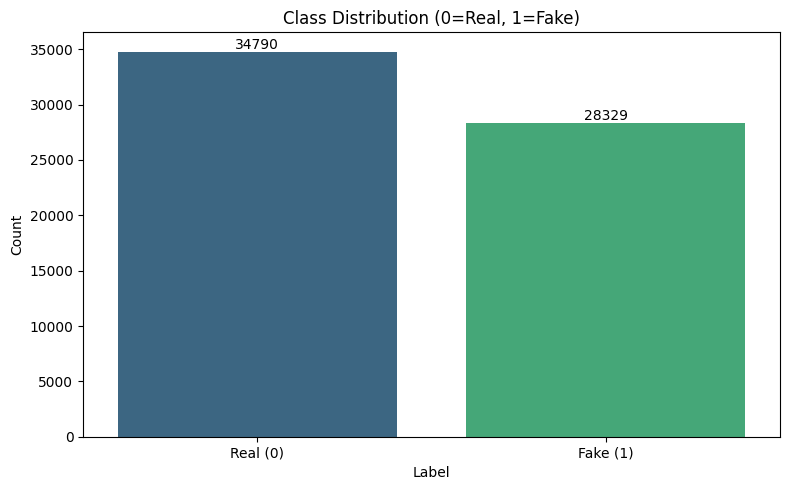

In [10]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=cfg.label_col, data=df, palette='viridis')
ax.set_title("Class Distribution (0=Real, 1=Fake)")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_xticklabels(["Real (0)", "Fake (1)"]) 

for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()


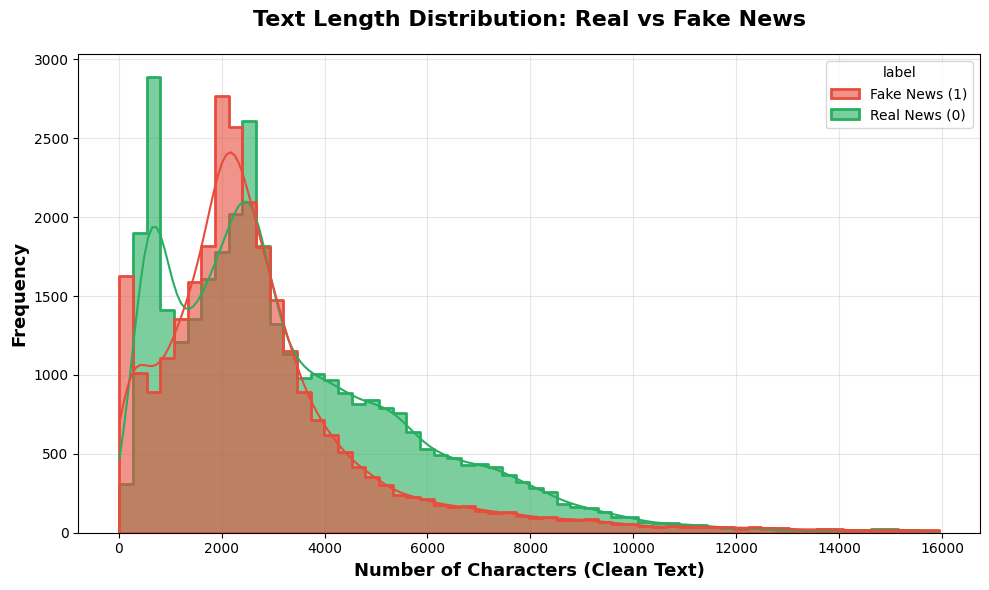

In [11]:
df['text_length'] = df[cfg.clean_col].str.len()

# Define the threshold to remove extreme outliers (99th percentile)
max_length = df['text_length'].quantile(0.99)

df_viz = df[df['text_length'] <= max_length].copy()

# MAPPING: 0 is Real, 1 is Fake
df_viz[cfg.label_col] = df_viz[cfg.label_col].map({0: 'Real News (0)', 1: 'Fake News (1)'})

fig, ax = plt.subplots(figsize=(10, 6))

# Real (0) = Green, Fake (1) = Red
my_palette = {
    'Real News (0)': '#27ae60',
    'Fake News (1)': '#e74c3c'
}

sns.histplot(data=df_viz, x='text_length', hue=cfg.label_col, 
             kde=True, bins=60, element="step",
             palette=my_palette, 
             alpha=0.6, linewidth=2, ax=ax)

ax.set_title("Text Length Distribution: Real vs Fake News", 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Number of Characters (Clean Text)", fontsize=13, fontweight='bold')
ax.set_ylabel("Frequency", fontsize=13, fontweight='bold')

ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [12]:
# Print statistics
print(f"Min: {df['text_length'].min()} characters")
print(f"Max: {df['text_length'].max()} characters")
print(f"Mean: {df['text_length'].mean():.2f} characters")
print(f"Median: {df['text_length'].median():.2f} characters")

Min: 13 characters
Max: 143036 characters
Mean: 3365.85 characters
Median: 2536.00 characters


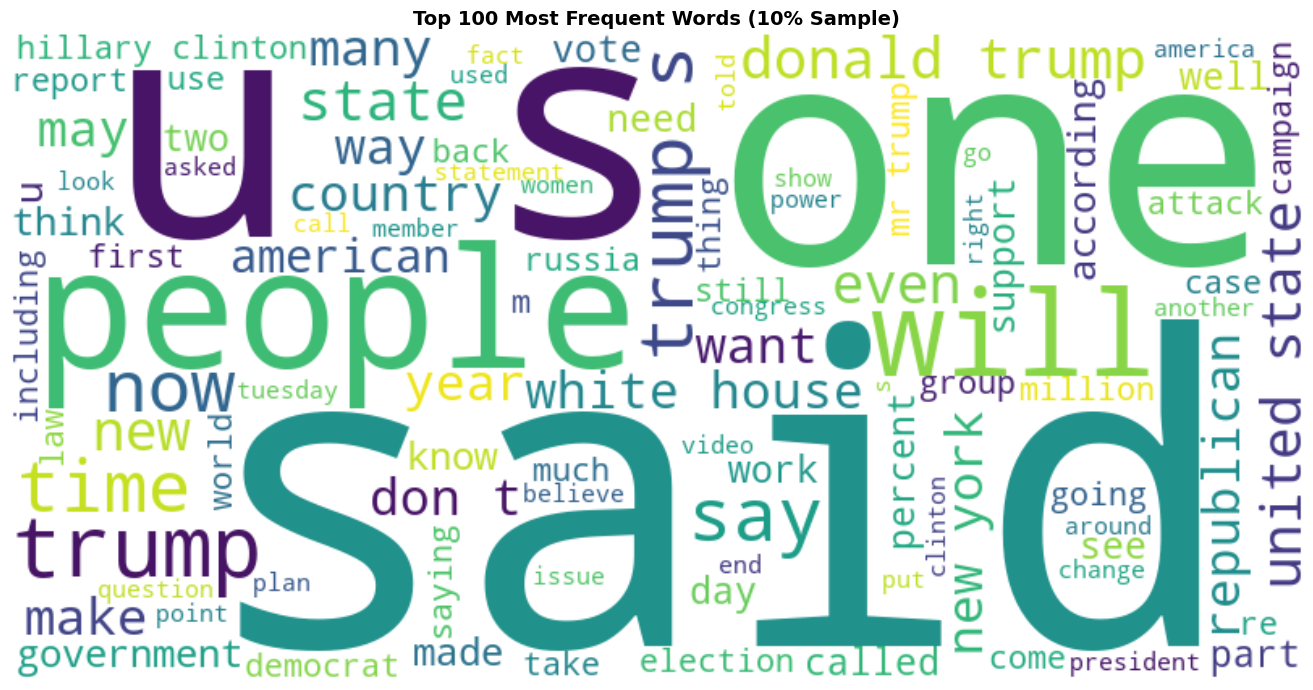

In [14]:
# Sample 20% of data to generate wordcloud faster (representative sample)
sample_size = int(len(df) * 0.2)
df_sample = df.sample(n=sample_size, random_state=cfg.seed)

# Combine text from sample only
all_text = " ".join(df_sample[cfg.clean_col].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=100, colormap='viridis').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 100 Most Frequent Words (10% Sample)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# Count word occurrences to identify most common terms
words = all_text.split()
word_counts = Counter(words)

print("\nTOP 20 MOST FREQUENT WORDS:")
for i, (word, count) in enumerate(word_counts.most_common(20), 1):
    print(f"{i:2d}.{word:20s}:{count:6d} occurrences")


TOP 20 MOST FREQUENT WORDS:
 1.the                 :400251 occurrences
 2.to                  :202067 occurrences
 3.of                  :179699 occurrences
 4.and                 :163211 occurrences
 5.a                   :159917 occurrences
 6.in                  :137873 occurrences
 7.that                : 89768 occurrences
 8.on                  : 66832 occurrences
 9.for                 : 66264 occurrences
10.is                  : 65754 occurrences
11.he                  : 47279 occurrences
12.with                : 45631 occurrences
13.was                 : 44156 occurrences
14.as                  : 42689 occurrences
15.it                  : 40741 occurrences
16.by                  : 36027 occurrences
17.his                 : 35151 occurrences
18.have                : 32169 occurrences
19.be                  : 31922 occurrences
20.has                 : 31867 occurrences
